In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler



In [2]:
from PIL import Image

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
class Expression(Dataset):
    def __init__(self, transform=None):
        
        xy = np.loadtxt('/content/drive/MyDrive/train_data.csv', delimiter=',', dtype=np.float32, skiprows=0)
        target = np.loadtxt('/content/drive/MyDrive/train_target.csv', delimiter=',', dtype=np.int64, skiprows=0)
        self.n_samples = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, :])  #.reshape((1,self.n_samples,2304)) # size [n_samples, n_features]
        
        self.y_data = torch.from_numpy(target[:])#.reshape((1,self.n_samples,1)) # size [n_samples, 1
        self.transform = transform



    def __getitem__(self, index):
        sample = self.x_data[index]
        if self.transform:
          inputs=transforms.ToPILImage()(self.x_data[index].reshape(48,48))
          inputs =torchvision.transforms.functional.resize(inputs, (224,224), interpolation=2)
          #self.x_data[index]
          sample = transforms.ToTensor()(inputs)
        return sample, self.y_data[index]

    def __len__(self):
        return self.n_samples


In [5]:
class ExpressionTest(Dataset):
    def __init__(self, transform=None):
        
        xy = np.loadtxt('/content/drive/MyDrive/test_data.csv', delimiter=',', dtype=np.float32, skiprows=0)
        self.n_samples = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, :])  #.reshape((1,self.n_samples,2304)) # size [n_samples, n_features]
        
        self.transform = transform

    def __getitem__(self, index):
        sample = self.x_data[index]
        if self.transform:
          inputs = transforms.ToPILImage()(self.x_data[index].reshape(48,48))
          inputs = torchvision.transforms.functional.resize(inputs, (224,224), interpolation=2)
          #self.x_data[index]
          sample = transforms.ToTensor()(inputs)
          #self.x_data[index]
          
          
        return sample

    def __len__(self):
        return self.n_samples


In [6]:
# create dataset
dataset = Expression(True)


In [7]:
test_dataset = ExpressionTest(True)

(tensor([[[0.4314, 0.4314, 0.4314,  ..., 0.6980, 0.6980, 0.6980],
         [0.4314, 0.4314, 0.4314,  ..., 0.6980, 0.6980, 0.6980],
         [0.4314, 0.4314, 0.4314,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6824, 0.6824, 0.6784,  ..., 0.6863, 0.6863, 0.6863],
         [0.6824, 0.6824, 0.6784,  ..., 0.6863, 0.6863, 0.6863],
         [0.6824, 0.6824, 0.6784,  ..., 0.6863, 0.6863, 0.6863]]]), tensor(1))
torch.Size([1, 224, 224])


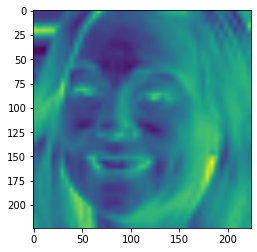

In [8]:
print(dataset[0])
first_data = dataset[0]
print(first_data[0].shape)
plt.imshow(first_data[0].reshape(224,224))

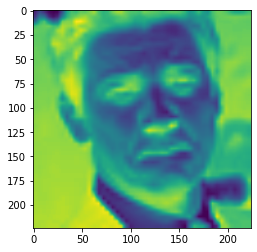

In [9]:
first_data_test = test_dataset
print(first_data_test)
plt.imshow(first_data_test[0].reshape(224,224))


In [10]:
trainloader = DataLoader(dataset=dataset,
                         batch_size=5,
                         shuffle=True,
                         num_workers=2)

In [11]:
testloader = DataLoader(dataset=test_dataset,
                          batch_size=5,
                          shuffle=False,
                          num_workers=2)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
# Use a pre-trained ResNet18
from torchvision import datasets, transforms, models

model = models.resnet18(pretrained=True)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, padding = 3, stride = 2)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, (3))

model.to(device)

# Specity the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [20]:
def train(net):
    loss_list = []
    start = time.time()
    model.train()
    counter_loss = []
    index = 0
    accuracy = []
    acc_val = 0
    for epoch in range(25): 
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # data pixels and labels to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.reshape(5,1,224,224)
            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            # propagate the loss backward
            loss.backward()
            optimizer.step()
            # print for mini batches
            running_loss += loss.item()
            if i % 1000 == 999:  # every 5000 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss/1000))
                running_loss = 0.0
            loss_list.append(running_loss)
            index += 1
            counter_loss.append(index)
        print("epoch",epoch)
        acc_val = compute_accuracy()
        accuracy.append(acc_val)

    scheduler.step()
    end = time.time()
    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
    return loss_list, acc_val, counter_loss


In [22]:
loss_vals = []
accuracy = []
counter_l = []
loss_vals, accuracy, counter_l = train(model)

[Epoch 1,  1000 Mini Batches] loss: 1.016
[Epoch 1,  2000 Mini Batches] loss: 0.779
[Epoch 1,  3000 Mini Batches] loss: 0.673
epoch 0
Accuracy of the network on test images: 76.266 %
[Epoch 2,  1000 Mini Batches] loss: 0.585
[Epoch 2,  2000 Mini Batches] loss: 0.546
[Epoch 2,  3000 Mini Batches] loss: 0.551
epoch 1
Accuracy of the network on test images: 82.560 %
[Epoch 3,  1000 Mini Batches] loss: 0.454
[Epoch 3,  2000 Mini Batches] loss: 0.472
[Epoch 3,  3000 Mini Batches] loss: 0.459
epoch 2
Accuracy of the network on test images: 86.269 %
[Epoch 4,  1000 Mini Batches] loss: 0.376
[Epoch 4,  2000 Mini Batches] loss: 0.379
[Epoch 4,  3000 Mini Batches] loss: 0.382
epoch 3
Accuracy of the network on test images: 89.348 %
[Epoch 5,  1000 Mini Batches] loss: 0.300
[Epoch 5,  2000 Mini Batches] loss: 0.326
[Epoch 5,  3000 Mini Batches] loss: 0.313
epoch 4
Accuracy of the network on test images: 92.791 %
[Epoch 6,  1000 Mini Batches] loss: 0.215
[Epoch 6,  2000 Mini Batches] loss: 0.256
[

In [21]:

def compute_accuracy():
  correct = 0
  total = 0
  with torch.no_grad():
      for data in trainloader:
          inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
          inputs = inputs.reshape(5,1,224,224)
          outputs = model(inputs.float())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy of the network on test images: %0.3f %%' % (
      100 * correct / total))
  return 100 * correct / total

In [ ]:
# Loss Plot 
print(counter)

NameError: ignored

In [ ]:
#test 
correct = 0
total = 0
pred_val = []
with torch.no_grad():
    for data in testloader:
        inputs = data[:].to(device, non_blocking=True)
        
        inputs = inputs.reshape(5,1,224,224)
        
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.tolist()       
        pred_val.append(predicted)

print(pred_val)

[[2, 0, 0, 1, 0], [0, 2, 1, 0, 1], [2, 1, 1, 1, 1], [2, 1, 1, 2, 1], [2, 1, 1, 1, 1], [2, 1, 1, 2, 0], [1, 2, 2, 1, 1], [1, 1, 2, 0, 0], [1, 1, 2, 2, 2], [1, 1, 1, 0, 1], [1, 1, 0, 0, 0], [2, 0, 1, 1, 1], [1, 0, 2, 1, 2], [1, 1, 1, 2, 1], [1, 1, 2, 1, 1], [0, 2, 1, 1, 2], [1, 2, 1, 2, 1], [2, 2, 1, 2, 1], [1, 1, 2, 2, 0], [1, 2, 1, 1, 2], [0, 2, 0, 0, 1], [1, 0, 1, 1, 1], [0, 2, 1, 1, 0], [1, 0, 2, 2, 0], [1, 1, 0, 1, 1], [0, 2, 2, 1, 2], [0, 1, 2, 1, 0], [1, 1, 1, 2, 2], [1, 0, 2, 1, 1], [1, 1, 0, 2, 2], [2, 1, 1, 0, 0], [1, 2, 1, 1, 1], [1, 0, 2, 2, 1], [2, 2, 2, 1, 1], [2, 2, 0, 0, 1], [2, 0, 0, 1, 2], [2, 0, 2, 2, 1], [1, 2, 0, 0, 2], [1, 1, 0, 2, 0], [1, 1, 1, 0, 1], [2, 1, 1, 1, 2], [1, 1, 2, 2, 0], [1, 2, 1, 2, 2], [0, 2, 2, 0, 2], [2, 2, 1, 2, 1], [0, 1, 0, 2, 1], [1, 2, 1, 2, 0], [1, 1, 2, 1, 2], [1, 2, 2, 1, 1], [2, 1, 1, 0, 1], [2, 1, 1, 2, 0], [1, 1, 1, 1, 2], [2, 0, 0, 1, 2], [0, 2, 2, 1, 1], [0, 1, 1, 2, 2], [1, 1, 2, 0, 1], [1, 1, 1, 1, 0], [1, 2, 2, 2, 2], [0, 0, 0, 2, 

In [ ]:
import itertools
import csv

merged = list(itertools.chain(*pred_val))
merged = zip(merged)
print(merged)

with open('pred.csv', "w") as f:
    writer = csv.writer(f)
    for row in merged:
        writer.writerow(row)


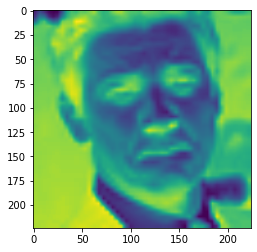

In [ ]:
for i in range(1):
  plt.imshow(test_dataset[0].reshape(224,224))

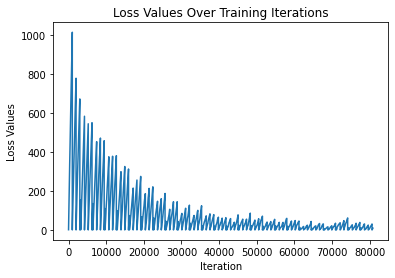

In [30]:
plt.plot(counter_l,loss_vals)
plt.title("Loss Values Over Training Iterations")
plt.xlabel('Iteration')
plt.ylabel("Loss Values")
plt.show()

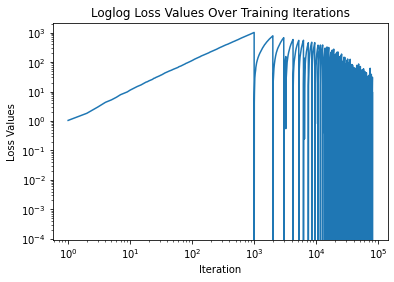

In [35]:
plt.loglog(counter_l,loss_vals)
plt.title("Loglog Loss Values Over Training Iterations")
plt.xlabel('Iteration')
plt.ylabel("Loss Values")
plt.show()

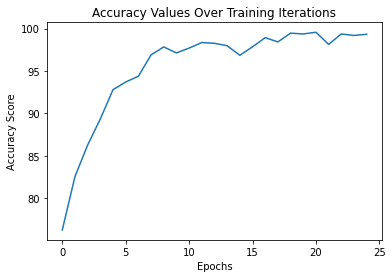

In [31]:
plt.plot(range(25),acc)
plt.title("Accuracy Values Over Training Iterations")
plt.xlabel('Epochs')
plt.ylabel("Accuracy Score")
plt.show()

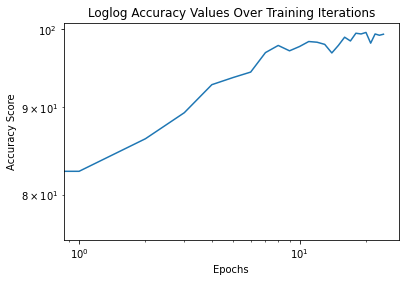

In [34]:
plt.loglog(range(25),acc)
plt.title("Loglog Accuracy Values Over Training Iterations")
plt.xlabel('Epochs')
plt.ylabel("Accuracy Score")
plt.show()